In [1]:
!pip install seaborn

In [2]:
import h5py
import cv2
from PIL import Image
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [4]:
with h5py.File('/kaggle/input/sorokhpoth-data/sorokhpoth_dataset.h5', 'r') as file:
    images = file['images'][:]
    labels = file['labels'][:]

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '/kaggle/input/sorokhpoth-data/sorokhpoth_dataset.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
print('Total number of images: ',len(images))
print('Total number of labels: ',len(labels))

unique_classes, class_counts = np.unique(labels, return_counts=True)
for class_label, count in zip(unique_classes, class_counts):
    print(f"Class {class_label}: {count} samples")

In [ ]:
resized_images = [Image.fromarray(image).resize((224, 224)) for image in images]
resized_images = np.array([preprocess_input(np.array(image)) for image in resized_images])

In [ ]:
def adjust_brightness(image, factor):
    image = image.astype(np.float32)
    augmented_image = image + factor
    augmented_image = np.clip(augmented_image, 0, 255)
    augmented_image = augmented_image.astype(np.uint8)
    return augmented_image

def flip_image(image, flip_code):
    return cv2.flip(image, flip_code)

def rotate_image(image, angle):
    rows, cols = image.shape[:2]
    M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
    return cv2.warpAffine(image, M, (cols, rows))

def zoom_image(image, zoom_factor):
    rows, cols = image.shape[:2]
    M = cv2.getRotationMatrix2D((cols / 2, rows / 2), 0, zoom_factor)
    return cv2.warpAffine(image, M, (cols, rows))

def shift_image(image, dx, dy):
    rows, cols = image.shape[:2]
    M = np.float32([[1, 0, dx], [0, 1, dy]])
    return cv2.warpAffine(image, M, (cols, rows))

In [ ]:
augmented_images = []
augmented_labels = []

for img, label in zip(resized_images, labels):
    augmented_img_brightness = adjust_brightness(img, 50)

    augmented_img_flip_horizontal = flip_image(img, 1)
    augmented_img_flip_vertical = flip_image(img, 0)

    augmented_img_rotate = rotate_image(img, 30)

    augmented_img_zoom = zoom_image(img, 1.2)

    augmented_img_shift = shift_image(img, 20, 20)

    augmented_images.extend([
        img,
        augmented_img_brightness,
        augmented_img_flip_horizontal,
        augmented_img_flip_vertical,
        augmented_img_rotate,
        augmented_img_zoom,
        augmented_img_shift
    ])

    augmented_labels.extend([label] * 7)

In [ ]:
print('Total number of augmented images: ',len(augmented_images))
print('Total number of augmented labels: ',len(augmented_labels))

unique_classes_aug, class_counts_aug = np.unique(augmented_labels, return_counts=True)
for class_label, count in zip(unique_classes_aug, class_counts_aug):
    print(f"Class {class_label}: {count} samples")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

class_labels_str = [label.decode('utf-8') for label in unique_classes_aug]

# Plotting the bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(class_labels_str, class_counts_aug, color='blue')
plt.title('Dataset: BIT-Vehicle')
plt.xlabel('Class Label')
plt.ylabel('Number of Samples')

# Rotate x-axis labels
plt.xticks(rotation=45, ha='right')

# Display the value on top of each bar
for bar, count in zip(bars, class_counts_aug):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 50, round(count, 2), ha='center', va='bottom')

plt.savefig('/kaggle/working/BIT-Vehicle_Aug.png')
plt.show()

In [9]:
images = np.array(augmented_images)
num_classes = len(np.unique(augmented_labels))
print('Number of classes',num_classes)

Number of classes 10


In [10]:
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(augmented_labels)
label_mapping = {i: label for i, label in enumerate(label_encoder.classes_)}

In [11]:
labels = to_categorical(encoded_labels, num_classes)
unique_labels_set = set(tuple(label) for label in labels)
for unique_label in unique_labels_list:
    print(unique_label)

[0. 1.]


In [12]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224,224,3))

x = base_model.layers[-1].output

x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

learning_rate = 0.0001
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

87910968/87910968 [==============================] - 1s 0us/step


In [13]:
k = 3
epochs = 3
batch_size = 32
kf = KFold(n_splits=k, shuffle=True)

accuracy_values = []
precision_values = []
recall_values = []
f1_score_values = []

confusion_matrices = []
all_true_labels = []
all_pred_labels = []
model_history = []

for fold, (train_index, test_index) in enumerate(kf.split(images), 1):
    print("Fold:", fold)
    X_train_fold, X_test_fold = images[train_index], images[test_index]
    y_train_fold, y_test_fold = labels[train_index], labels[test_index]

    history = model.fit(X_train_fold, y_train_fold, epochs=epochs, batch_size=batch_size)

    y_pred = model.predict(X_test_fold)
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true_labels = np.argmax(y_test_fold, axis=1)

    
    cm = confusion_matrix(y_true_labels, y_pred_labels)
    report = classification_report(y_true_labels, y_pred_labels, output_dict=True)
    
    confusion_matrices.append(cm)
    accuracy_values.append(report['accuracy'])
    precision_values.append(report['weighted avg']['precision'])
    recall_values.append(report['weighted avg']['recall'])
    f1_score_values.append(report['weighted avg']['f1-score'])

    all_true_labels.extend(y_true_labels)
    all_pred_labels.extend(y_pred)
    model_history.append(history)
    
avg_accuracy = np.mean(accuracy_values)
avg_weighted_precision = np.mean(precision_values)
avg_weighted_recall = np.mean(recall_values)
avg_weighted_f1_score = np.mean(f1_score_values)

print('Average accuracy:', avg_accuracy)
print('Average weighted precision:', avg_weighted_precision)
print('Average weighted recall:', avg_weighted_recall)
print('Average weighted f1 score:', avg_weighted_f1_score)

Fold: 1
Epoch 1/3
693/693 [==============================] - 154s 215ms/step - loss: 1.5302 - accuracy: 0.5177
Epoch 2/3
693/693 [==============================] - 143s 206ms/step - loss: 0.7907 - accuracy: 0.7186
Epoch 3/3
347/347 [==============================] - 69s 195ms/step
Fold: 2
Epoch 1/3
693/693 [==============================] - 139s 200ms/step - loss: 0.6112 - accuracy: 0.7818
Epoch 2/3
693/693 [==============================] - 139s 201ms/step - loss: 0.5604 - accuracy: 0.8008
Epoch 3/3
347/347 [==============================] - 66s 191ms/step
Fold: 3
Epoch 1/3
693/693 [==============================] - 138s 199ms/step - loss: 0.5202 - accuracy: 0.8117
Epoch 2/3
693/693 [==============================] - 137s 197ms/step - loss: 0.4958 - accuracy: 0.8186
Epoch 3/3
347/347 [==============================] - 65s 188ms/step
Average accuracy: 0.8243315919481992
Average weighted precision: 0.8880407691757067
Average weighted recall: 0.8243315919481992
Average weighted f1 score:

In [14]:
all_pred_labels = np.array(all_pred_labels)
all_true_labels = np.array(all_true_labels)
n_classes = len(np.unique(all_true_labels))
all_true_labels_binarized = label_binarize(all_true_labels, classes=range(n_classes))
true = all_true_labels_binarized.ravel()
pred = all_pred_labels.ravel()

In [15]:
roc_values = pd.DataFrame({
    'True_Class': true,
    'Pred_Class': pred,
})

roc_values.to_csv('/kaggle/working/SorokhPoth_Inceptionv3_ROC.csv', index=False)

In [16]:
learning_curves = pd.DataFrame({
    'Precision': precision_values,
    'Recall': recall_values,
    'F1_score': f1_score_values,
})

learning_curves.to_csv('/kaggle/working/SorokhPoth_Inceptionv3_Learning.csv', index=False)

In [17]:
history_values = pd.DataFrame({
    'History': model_history
})

history_values.to_csv('/kaggle/working/SorokhPoth_Inceptionv3_History.csv', index=False)

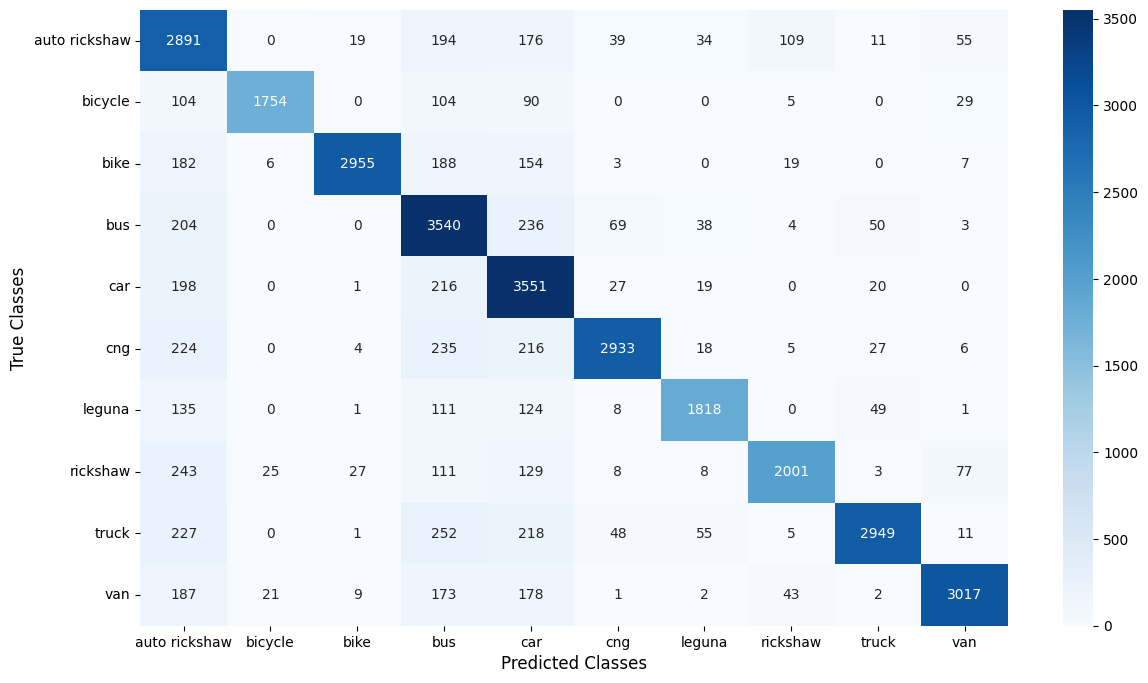

In [18]:
combined_conf_matrix = np.zeros((num_classes, num_classes), dtype=int)

for fold, cm in enumerate(confusion_matrices, 1):
    combined_conf_matrix += cm

conf_matrix_labels = [label_mapping[i] for i in range(len(label_mapping))]
conf_matrix_labels = [label.decode('utf-8')[0:] for label in conf_matrix_labels]

num_labels = len(conf_matrix_labels)
fig_width = min(max(14, num_labels * 0.5), 16)
fig_height = max(8, num_labels * 0.4)

plt.figure(figsize=(fig_width, fig_height))
plt.rcParams['figure.dpi'] = 300

sns.heatmap(combined_conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=conf_matrix_labels, yticklabels=conf_matrix_labels)
plt.xticks(rotation=0, fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.xlabel("Predicted Classes", fontsize=12)
plt.ylabel("True Classes", fontsize=12)
plt.savefig('/kaggle/working/confusion_matrix1-SorokhPoth_Inceptionv3.png', dpi=300, bbox_inches='tight')
plt.show()

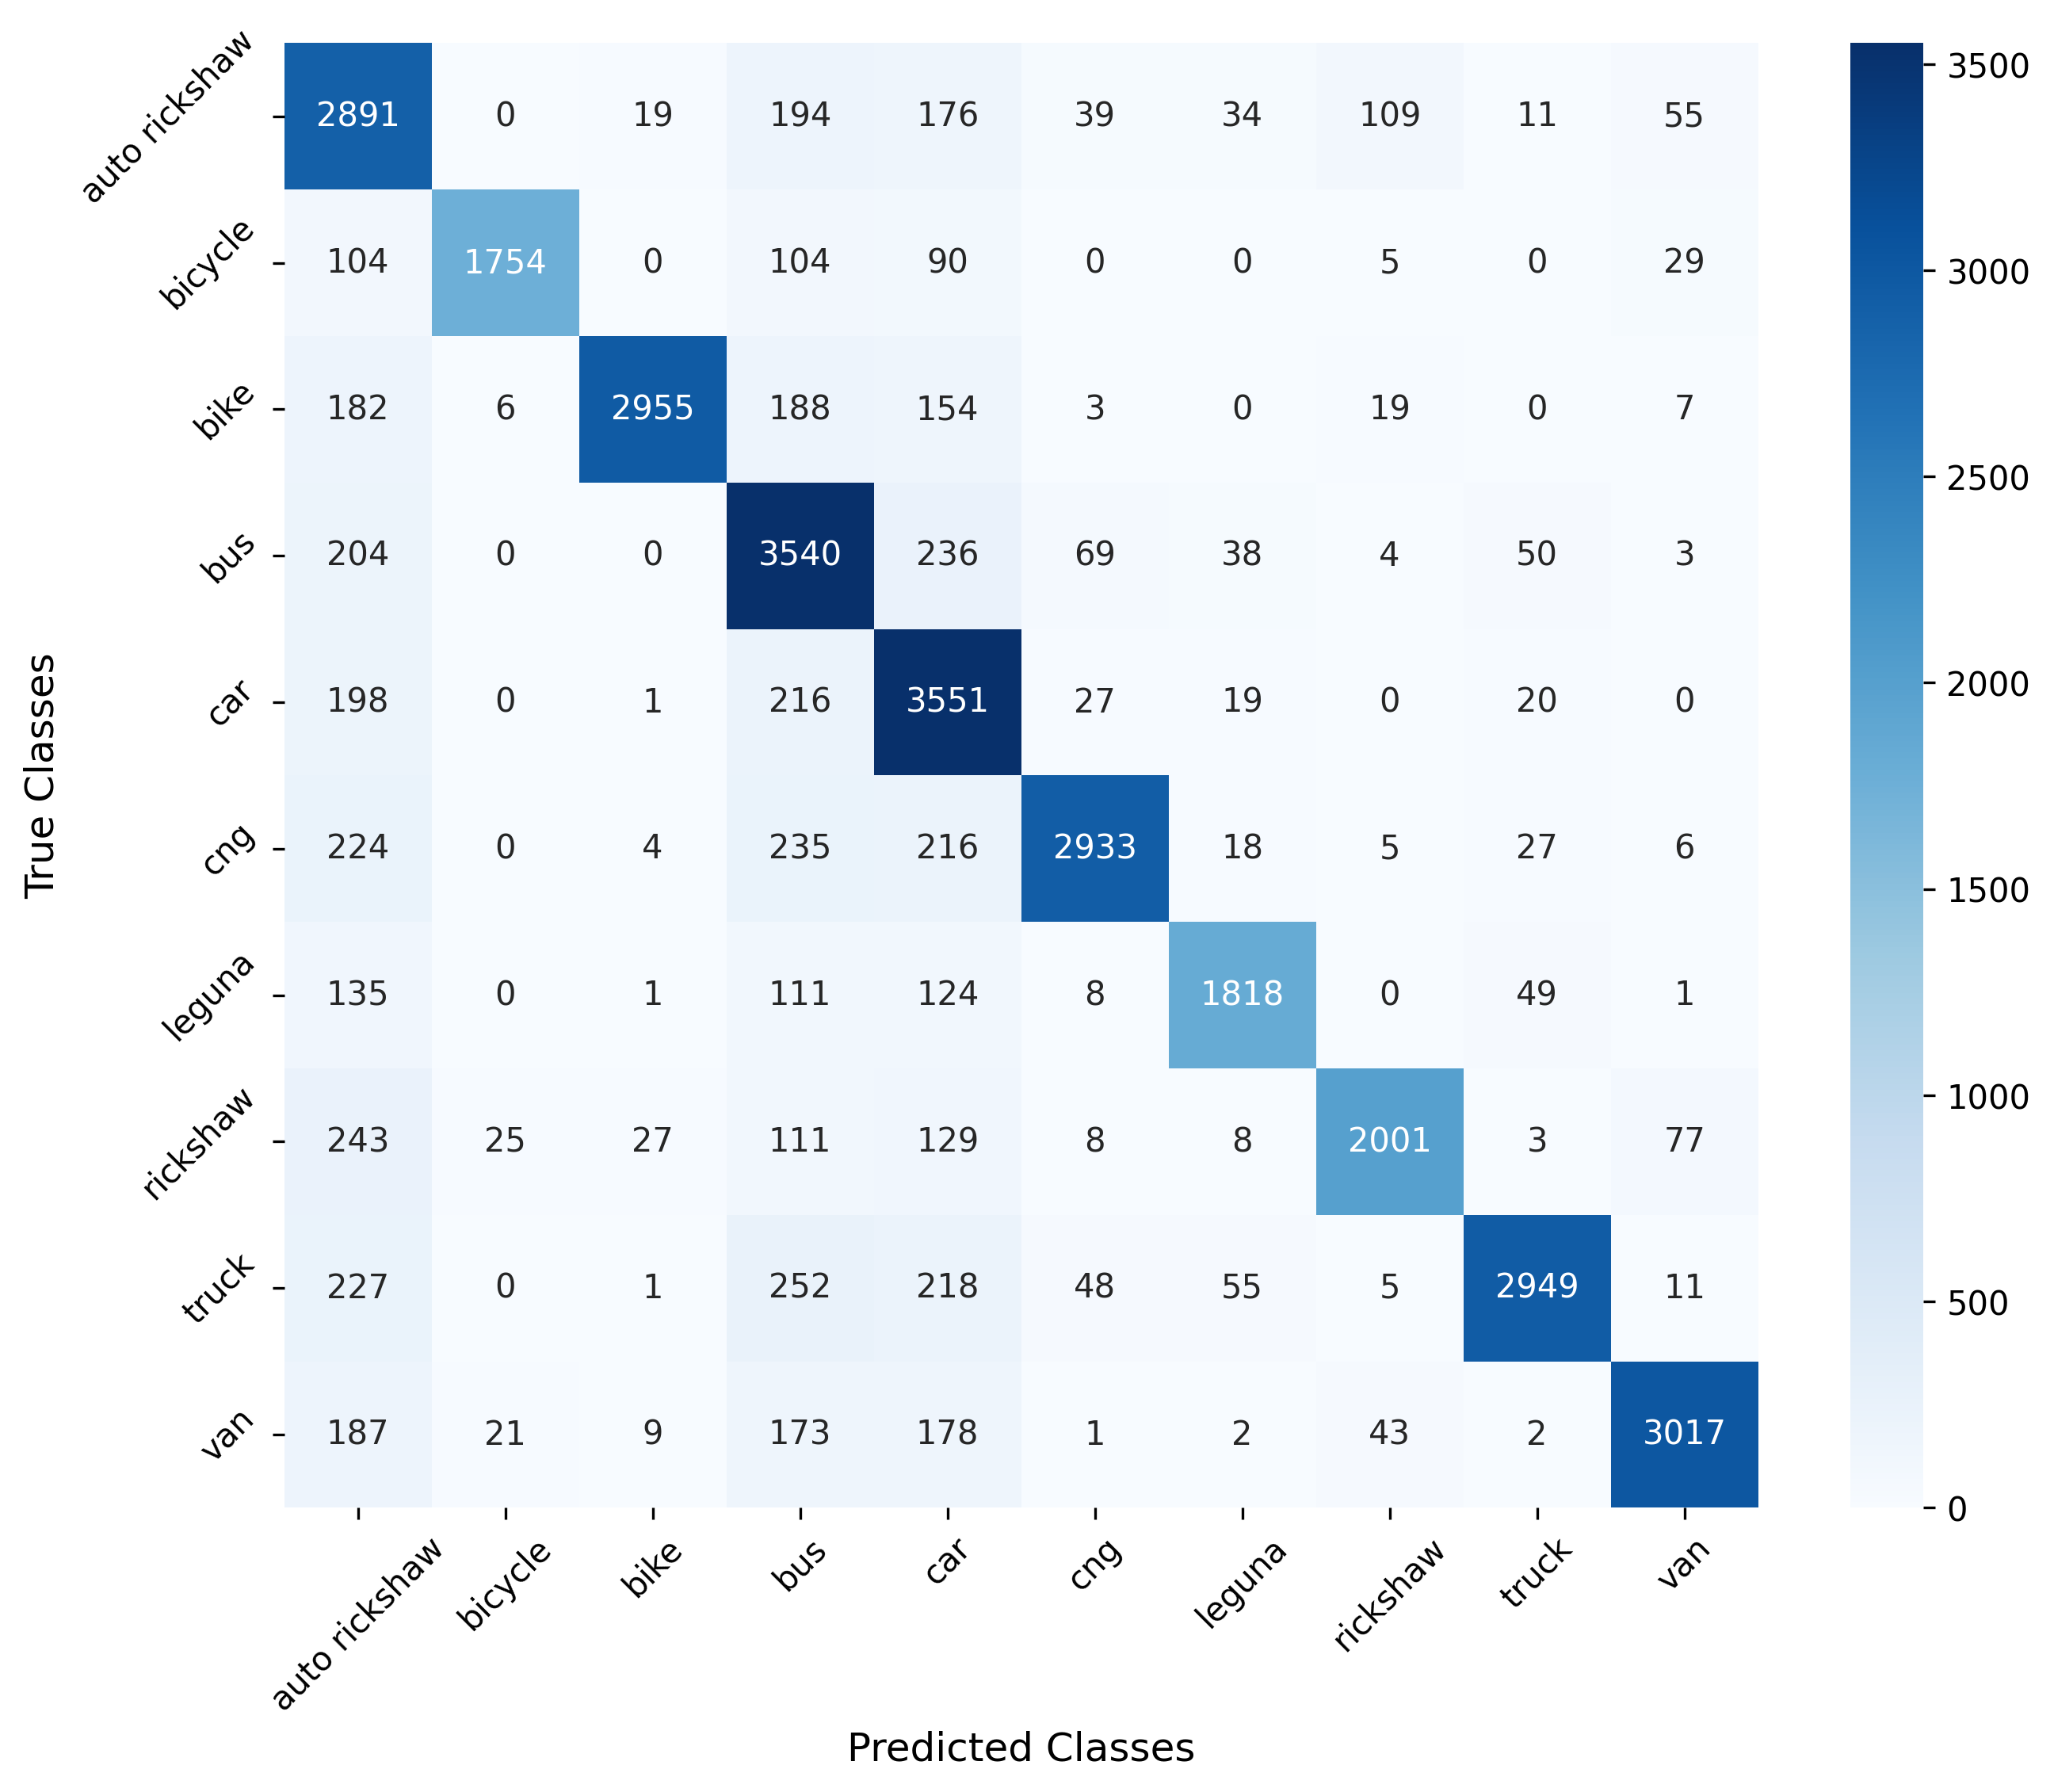

In [19]:
conf_matrix_labels = [label_mapping[i] for i in range(len(label_mapping))]
conf_matrix_labels = [label.decode('utf-8')[0:] for label in conf_matrix_labels]

num_labels = len(conf_matrix_labels)
fig_width = min(max(10, num_labels * 0.5), 12)
fig_height = max(8, num_labels * 0.4)

plt.figure(figsize=(fig_width, fig_height))
plt.rcParams['figure.dpi'] = 300

sns.heatmap(combined_conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=conf_matrix_labels, yticklabels=conf_matrix_labels)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(rotation=45, fontsize=10)
plt.xlabel("Predicted Classes", fontsize=12)
plt.ylabel("True Classes", fontsize=12)
plt.savefig('/kaggle/working/confusion_matrix2-SorokhPoth_Inceptionv3.png', dpi=300, bbox_inches='tight')
plt.show()